### 导入数据

In [32]:
%matplotlib inline
import os
import glob
import xgboost
import operator
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV,KFold, cross_val_predict,StratifiedKFold,train_test_split,cross_val_score,LeaveOneOut
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,plot_confusion_matrix,auc,roc_auc_score,roc_curve,plot_roc_curve,ConfusionMatrixDisplay,mean_squared_error
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings(action='ignore')

#导入数据
df_train = pd.read_excel(r"E:\Desktop\Desktop\Kidney\51例\vp.xlsx")
target_train=df_train.iloc[:,1:2]
features_train=df_train.iloc[:,2:102]
df_test = pd.read_excel(r"E:\Desktop\Desktop\Kidney\51例\vp_test.xlsx")
target_test=df_test.iloc[:,1:2]
features_test=df_test.iloc[:,2:102]
features_names=list(features_train.columns)

#标准化所有数据
scaler = StandardScaler()#scaler = MinMaxScaler()#scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(features_train),columns=features_names)
y_train = target_train
X_test = pd.DataFrame(scaler.fit_transform(features_test),columns=features_names)
y_test = target_test

#### SVM

RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_glcm_DifferenceVariance']
模型最佳参数为： {'clf__C': 0.1, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.6416666666666666


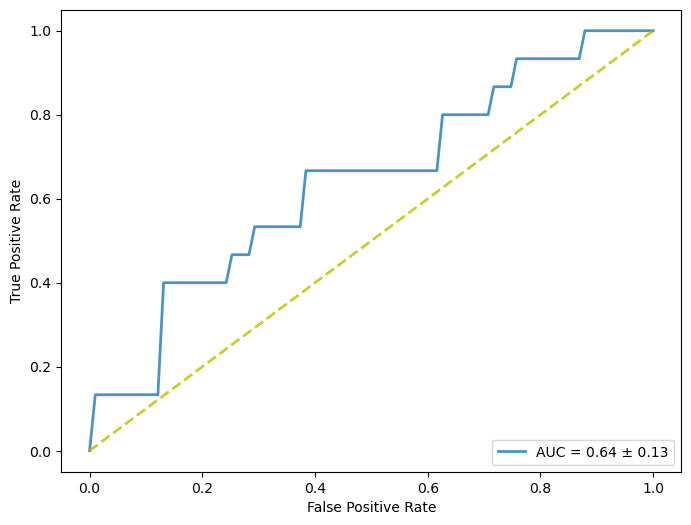

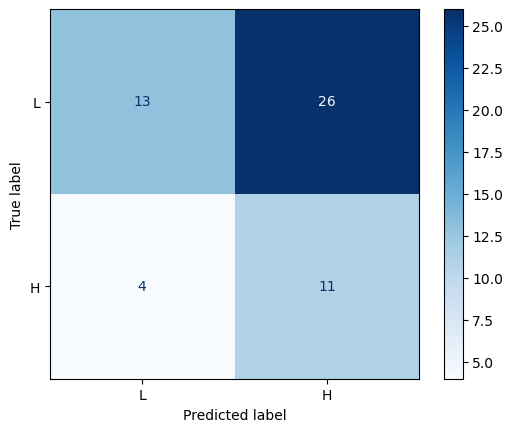

,Accuracy,AUC,Sensitivity (TPR),Specificity (TNR),F1 score
SVM,0.44 ± 0.10,0.64 ± 0.13,0.73 ± 0.13,0.33 ± 0.17,0.43 ± 0.05


In [27]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

#设置分类器
sm = SMOTE(random_state=1)
clf = SVC(kernel = "linear",random_state=1,class_weight="balanced",probability=True)
estimator = ([("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

#svmECV特征选择
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_train, y_train)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
names = list(X_train.columns[rfecv.support_])
select_features_train = X_train.loc[:, names]
print('选择的特征子集为：', names)
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
#print("Grid_Score: %f" % (g_scores[indices[0]]))

#模型网格寻优
model = Pipeline([("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
params = {'clf__kernel' : ['linear'],
          'clf__C' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,4,6,8,10,20]}    
grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, 
                           cv=cv, 
                           scoring=score,
                           n_jobs=-1,
                           refit='AUC',
                           return_train_score=True)
grid_search.fit(select_features_train, y_train)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

# 用最优模型训练结果
best_clf = grid_search.best_estimator_
con = 0
acc = []
auc_ = []
sen = []
spe = []
f1 = []
tpr_ = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features_train, y_train):
    X_train1 = select_features_train.iloc[train_index]
    y_train1 = y_train.iloc[train_index]
    X_test1 = select_features_train.iloc[test_index]
    y_test1 = y_train.iloc[test_index]

    best_clf.fit(X_train1, y_train1)
    y_pred = best_clf.predict(X_test1)
    proba = best_clf.predict_proba(X_test1)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test1, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0

    tpr_.append(interp_tpr)
    acc.append(accuracy_score(y_test1, y_pred))
    auc_.append(roc_auc_score(y_test1, proba))
    tn, fp, fn, tp = confusion_matrix(y_test1, y_pred).ravel()
    sen.append(tp / (tp + fn))
    spe.append(tn / (fp + tn))
    f1.append(f1_score(y_test1, y_pred))
    a=confusion_matrix(y_test1,y_pred)
    con=con+a

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
svm_mean_tpr = np.mean(tpr_, axis=0)
svm_mean_tpr[-1] = 1.0
svm_mean_auc = auc(mean_fpr, svm_mean_tpr)
svm_std_auc = np.std(auc_)
plt.plot(mean_fpr, svm_mean_tpr, label=f'AUC = {svm_mean_auc:.2f} ± {svm_std_auc:.2f}', lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='y', lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title=("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=con,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#模型结果
svm_result_dict = { 'Accuracy': [f'{np.mean(acc):.2f} ± {np.std(acc):.2f}'],
    'AUC': [f'{np.mean(auc_):.2f} ± {np.std(auc_):.2f}'],
    'Sensitivity (TPR)': [f'{np.mean(sen):.2f} ± {np.std(sen):.2f}'],
    'Specificity (TNR)': [f'{np.mean(spe):.2f} ± {np.std(spe):.2f}'],
    'F1 score': [f'{np.mean(f1):.2f} ± {np.std(f1):.2f}']
                }

result_svm = pd.DataFrame(svm_result_dict, index=['SVM'])
result_svm

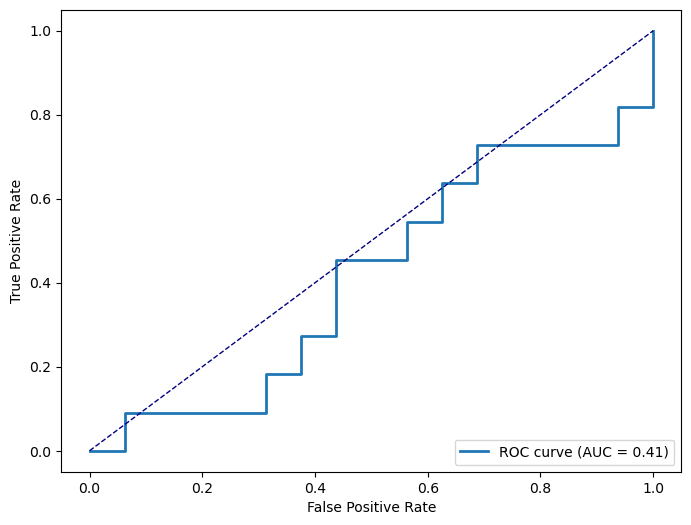

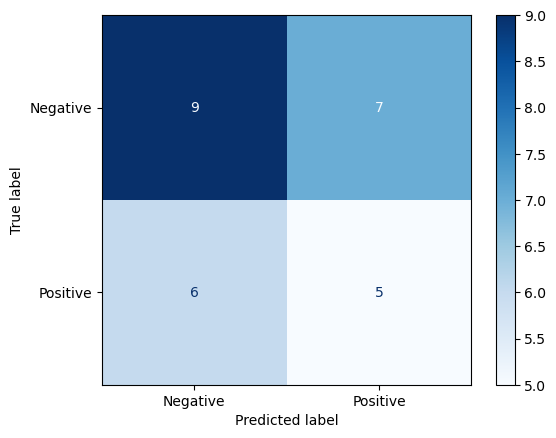

Accuracy: 0.5185185185185185
AUC: 0.4147727272727273
Sensitivity (TPR): 0.45454545454545453
Specificity (TNR): 0.5625
F1 Score: 0.43478260869565216


In [20]:
# 用最优模型测试结果
best_clf = grid_search.best_estimator_
select_features_test=X_test.loc[:, names]
##------------------------------------------测试集结果--------------------------------------------------------------------------------------
# Test the best model on the test set
y_pred = best_clf.predict(select_features_test)
y_proba = best_clf.predict_proba(select_features_test)[:, 1]

# Calculate evaluation metrics
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_mat.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim=[0.0, 1.0]
plt.ylim=[0.0, 1.05]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title=('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix
class_names = ['Negative', 'Positive']
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title=('Confusion Matrix - Test Set')
plt.show()

# Print evaluation metrics
print('Accuracy:', accuracy)
print('AUC:', roc_auc)
print('Sensitivity (TPR):', sensitivity)
print('Specificity (TNR):', specificity)
print('F1 Score:', f1)

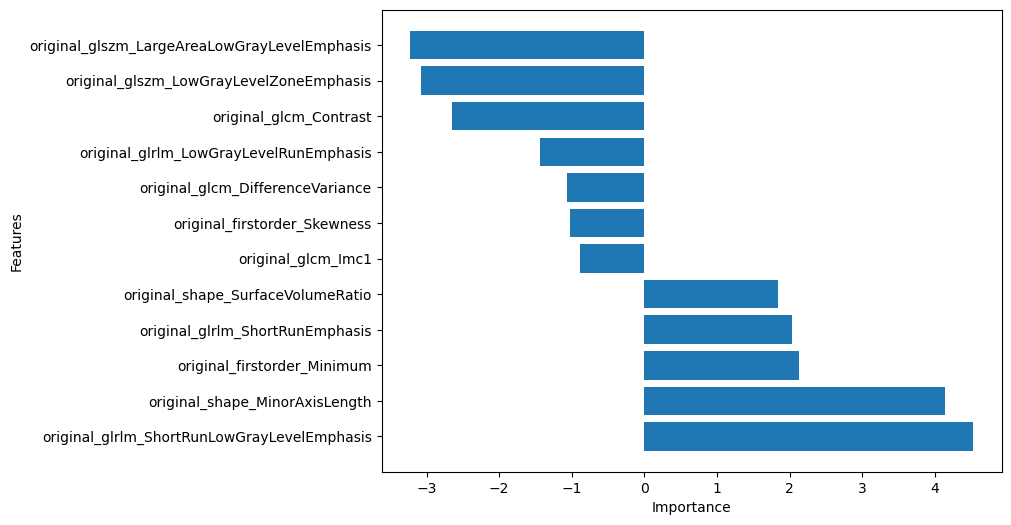

In [14]:
##显示特征重要性
# Assuming the best_clf is already fitted, you can access the feature importances as follows:
svm_feature_importances = best_clf.named_steps['clf'].coef_[0]

# Sort the feature importances in descending order and get the corresponding feature names
sorted_indices = svm_feature_importances.argsort()[::-1]  # 得到按重要性降序排列的索引
sorted_feature_importances = svm_feature_importances[sorted_indices]  # 按索引排序的特征重要性
sorted_feature_names = select_features_train.columns[sorted_indices]  # 按索引排序的特征名称

# Plot SVM feature importances in descending order
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances)  # 使用barh函数绘制横向条形图
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)  # 设置纵坐标刻度和标签
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title=("SVM Feature Importances (Sorted)")
plt.show()


#### 随机森林

In [30]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

#设置分类器
sm = SMOTE(random_state=150)
clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
estimator = ([("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

#svmECV特征选择
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_train, y_train)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
names = list(X_train.columns[rfecv.support_])
select_features_train = X_train.loc[:, names]
print('选择的特征子集为：', names)
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
#print("Grid_Score: %f" % (g_scores[indices[0]]))

#模型网格寻优
model = Pipeline([("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
params = {'clf__criterion' : ['gini'],
          'clf__max_features' : ["auto", "sqrt", "log2"],
          'clf__max_depth': [1,3,5,7,9],
          'clf__min_samples_leaf' : [2,4,6,8,10,11],
          'clf__min_samples_split' : [1,3,5,7,8],
          'clf__n_estimators': [5,7,9,11,12,15]}    
grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, 
                           cv=cv, 
                           scoring=score,
                           n_jobs=-1,
                           refit='AUC',
                           return_train_score=True)
grid_search.fit(select_features_train, y_train)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

# 用最优模型训练结果
best_clf = grid_search.best_estimator_
con = 0
acc = []
auc_ = []
sen = []
spe = []
f1 = []
tpr_ = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features_train, y_train):
    X_train1 = select_features_train.iloc[train_index]
    y_train1 = y_train.iloc[train_index]
    X_test1 = select_features_train.iloc[test_index]
    y_test1 = y_train.iloc[test_index]

    best_clf.fit(X_train1, y_train1)
    y_pred = best_clf.predict(X_test1)
    proba = best_clf.predict_proba(X_test1)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test1, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0

    tpr_.append(interp_tpr)
    acc.append(accuracy_score(y_test1, y_pred))
    auc_.append(roc_auc_score(y_test1, proba))
    tn, fp, fn, tp = confusion_matrix(y_test1, y_pred).ravel()
    sen.append(tp / (tp + fn))
    spe.append(tn / (fp + tn))
    f1.append(f1_score(y_test1, y_pred))
    a=confusion_matrix(y_test1,y_pred)
    con=con+a

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
rf_mean_tpr = np.mean(tpr_, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(mean_fpr,rf_mean_tpr)
rf_std_auc = np.std(auc_)
plt.plot(mean_fpr, rf_mean_tpr, label=f'AUC = {rf_mean_auc:.2f} ± {rf_std_auc:.2f}', lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='y', lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title=("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=con,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#模型结果
rf_result_dict = { 'Accuracy': [f'{np.mean(acc):.2f} ± {np.std(acc):.2f}'],
    'AUC': [f'{np.mean(auc_):.2f} ± {np.std(auc_):.2f}'],
    'Sensitivity (TPR)': [f'{np.mean(sen):.2f} ± {np.std(sen):.2f}'],
    'Specificity (TNR)': [f'{np.mean(spe):.2f} ± {np.std(spe):.2f}'],
    'F1 score': [f'{np.mean(f1):.2f} ± {np.std(f1):.2f}']
                }

result_rf = pd.DataFrame(rf_result_dict, index=['RF'])
result_rf

RFECV 选择出的特征个数 ： 1
选择的特征子集为： ['original_glszm_SmallAreaHighGrayLevelEmphasis']


KeyboardInterrupt: 

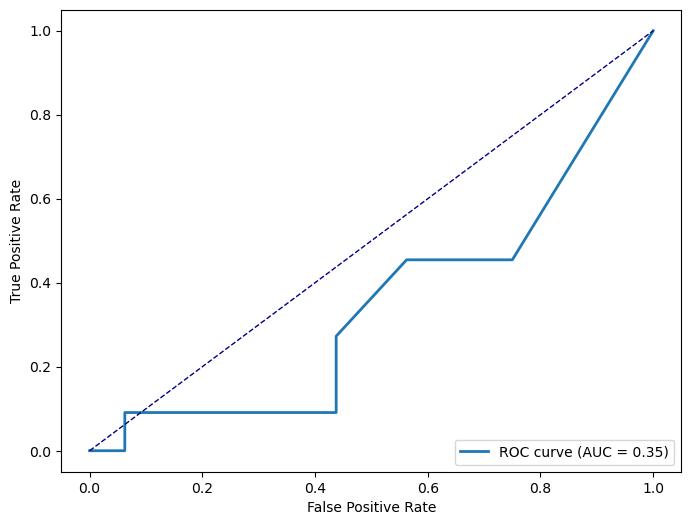

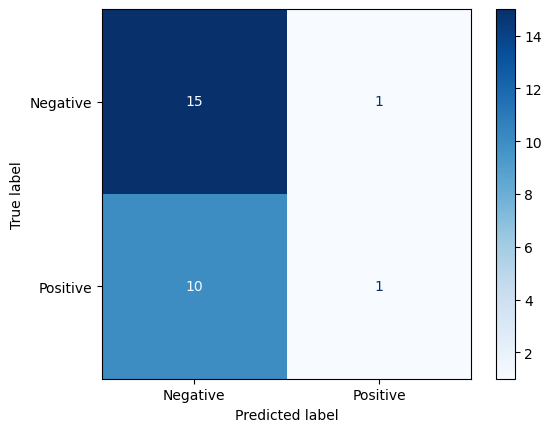

Accuracy: 0.5925925925925926
AUC: 0.34659090909090906
Sensitivity (TPR): 0.09090909090909091
Specificity (TNR): 0.9375
F1 Score: 0.15384615384615385


In [24]:
# 用最优模型测试结果
best_clf = grid_search.best_estimator_
select_features_test=X_test.loc[:, names]
##------------------------------------------测试集结果--------------------------------------------------------------------------------------
# Test the best model on the test set
y_pred = best_clf.predict(select_features_test)
y_proba = best_clf.predict_proba(select_features_test)[:, 1]

# Calculate evaluation metrics
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_mat.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim=[0.0, 1.0]
plt.ylim=[0.0, 1.05]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title=('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix
class_names = ['Negative', 'Positive']
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title=('Confusion Matrix - Test Set')
plt.show()

# Print evaluation metrics
print('Accuracy:', accuracy)
print('AUC:', roc_auc)
print('Sensitivity (TPR):', sensitivity)
print('Specificity (TNR):', specificity)
print('F1 Score:', f1)

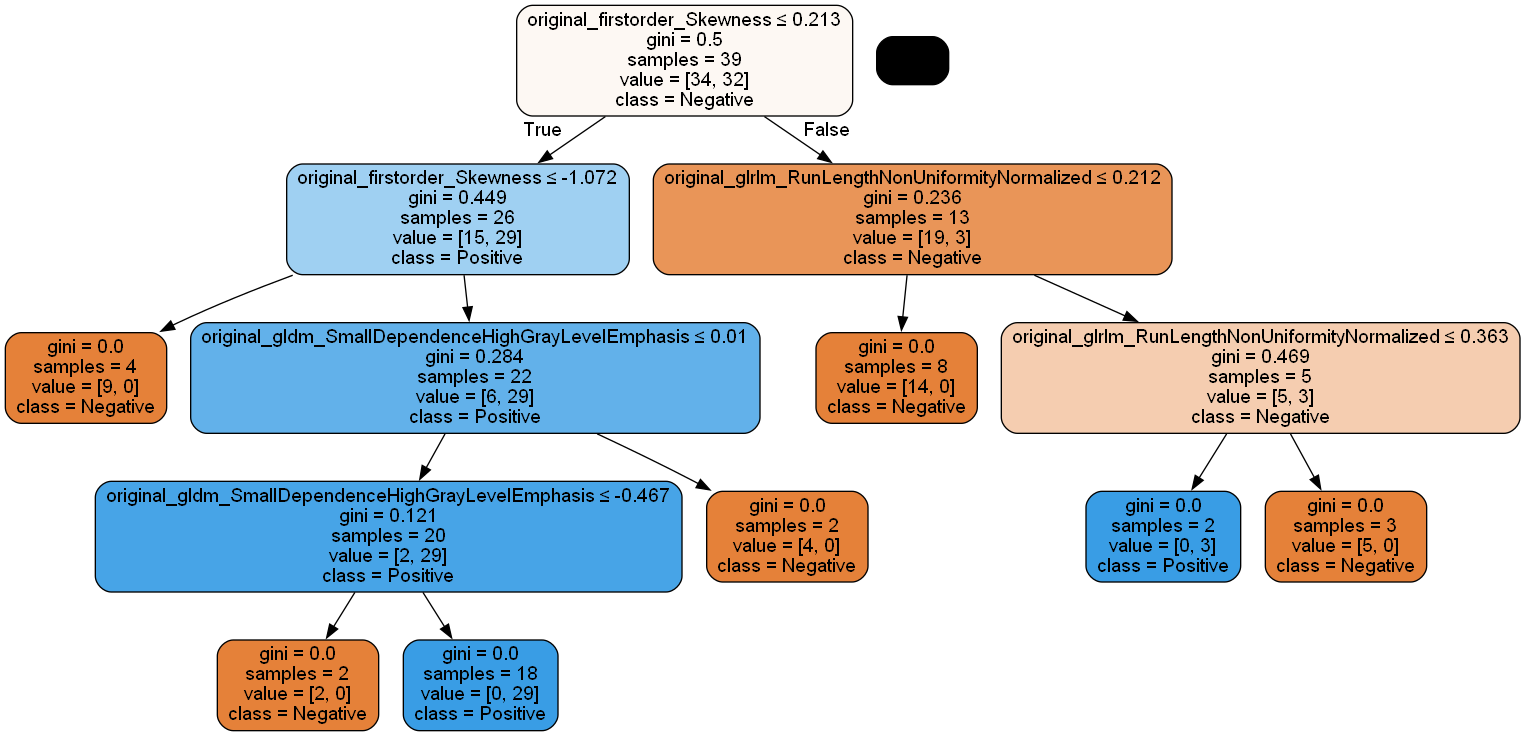

In [29]:
# 导入相关库
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import os

# ... (之前的代码)

# 获取最佳分类器中的所有决策树
all_trees = best_clf['clf'].estimators_

# 创建保存图像的文件夹
os.makedirs("rf_trees", exist_ok=True)

# 循环遍历并保存每棵决策树的可视化图像
for i, tree in enumerate(all_trees):
    dot_data = export_graphviz(tree, 
                               feature_names=names,  
                               class_names=class_names,
                               filled=True, 
                               rounded=True, 
                               special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    img_path = f"rf_trees/tree_{i}.png"
    graph.write_png(img_path)

# 在Jupyter Notebook中显示一棵决策树的示例
sample_tree = all_trees[0]
dot_data = export_graphviz(sample_tree, 
                           feature_names=names,  
                           class_names=class_names,
                           filled=True, 
                           rounded=True, 
                           special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


In [28]:
import shap
import matplotlib.pyplot as plt  # 指定绘图库的别名

# ... (之前的代码)

# 1. 计算SHAP值
explainer = shap.TreeExplainer(best_clf['clf'])
shap_values = explainer.shap_values(select_features)

# 2. 可视化SHAP值
shap.summary_plot(shap_values, select_features, feature_names=names, plot_type="bar")


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'>

TypeError: 'list' object is not callable

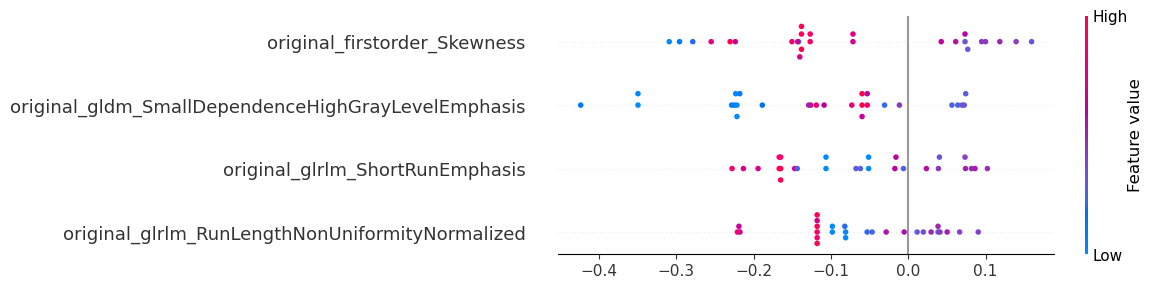

In [41]:
shap.summary_plot(shap_values[1], select_features, max_display=15)

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], select_features.iloc[0,:])

#### XGBoost

RFECV 选择出的特征个数 ： 12
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_Id', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_shape_Elongation', 'original_shape_Sphericity']
模型最佳参数为： {'clf__colsample_bytree': 0.9, 'clf__gamma': 0.8, 'clf__learning_rate': 0.09, 'clf__max_depth': 2, 'clf__min_child_weight': 1, 'clf__n_estimators': 8, 'clf__reg_alpha': 1, 'clf__reg_lambda': 3, 'clf__subsample': 0.8}
模型最佳AUC为： 0.961111111111111


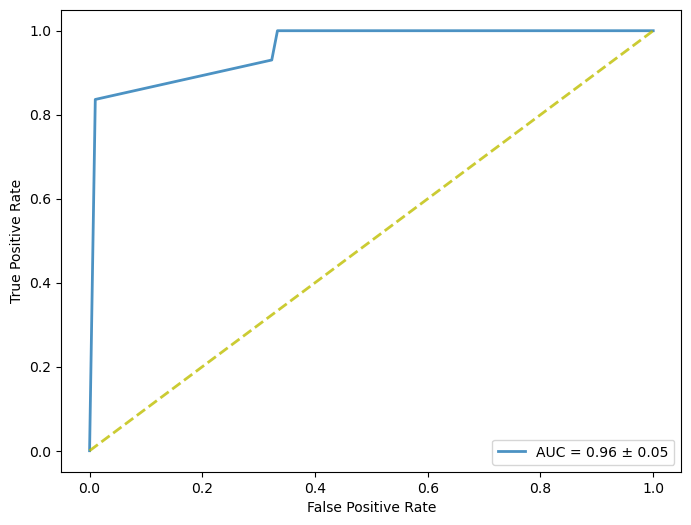

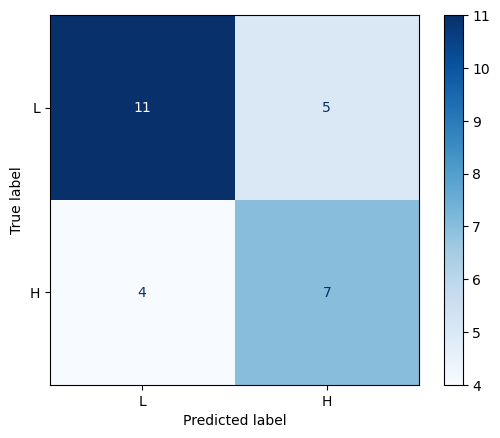

,Accuracy,AUC,Sensitivity (TPR),Specificity (TNR),F1 score
RF,0.66 ± 0.16,0.96 ± 0.05,0.63 ± 0.37,0.70 ± 0.40,0.54 ± 0.28


In [33]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

#设置分类器
sm = SMOTE(random_state=270)
clf = xgboost.XGBClassifier(random_state=1,n_jobs=-1)
estimator = ([("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

#svmECV特征选择
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_test, y_test)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
names = list(X_test.columns[rfecv.support_])
select_features_train = X_test.loc[:, names]
print('选择的特征子集为：', names)
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
#print("Grid_Score: %f" % (g_scores[indices[0]]))

#模型网格寻优
model = Pipeline([("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
params = {'clf__colsample_bytree' : [0.1,0.3,0.7,0.9],
              'clf__gamma' : [0.2,0.4,0.6,0.8],
              'clf__learning_rate' : [0.01,0.03,0.07,0.09],
              'clf__max_depth' : [2,4,8,10],
              'clf__min_child_weight' : [1,3,7,9],
              'clf__n_estimators' : [2,4,8,10],          
              'clf__reg_alpha' : [1,3,7,9],
              'clf__reg_lambda' : [1,3,7,9],
              'clf__subsample' : [0.2,0.4,0.8,1]}    
grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, 
                           cv=cv, 
                           scoring=score,
                           n_jobs=-1,
                           refit='AUC',
                           return_train_score=True)
grid_search.fit(select_features_train, y_test)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

# 用最优模型训练结果
best_clf = grid_search.best_estimator_
con = 0
acc = []
auc_ = []
sen = []
spe = []
f1 = []
tpr_ = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features_train, y_test):
    X_train1 = select_features_train.iloc[train_index]
    y_train1 = y_test.iloc[train_index]
    X_test1 = select_features_train.iloc[test_index]
    y_test1 = y_test.iloc[test_index]

    best_clf.fit(X_train1, y_train1)
    y_pred = best_clf.predict(X_test1)
    proba = best_clf.predict_proba(X_test1)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test1, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0

    tpr_.append(interp_tpr)
    acc.append(accuracy_score(y_test1, y_pred))
    auc_.append(roc_auc_score(y_test1, proba))
    tn, fp, fn, tp = confusion_matrix(y_test1, y_pred).ravel()
    sen.append(tp / (tp + fn))
    spe.append(tn / (fp + tn))
    f1.append(f1_score(y_test1, y_pred))
    a=confusion_matrix(y_test1,y_pred)
    con=con+a

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
rf_mean_tpr = np.mean(tpr_, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(mean_fpr,rf_mean_tpr)
rf_std_auc = np.std(auc_)
plt.plot(mean_fpr, rf_mean_tpr, label=f'AUC = {rf_mean_auc:.2f} ± {rf_std_auc:.2f}', lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='y', lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title=("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=con,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#模型结果
rf_result_dict = { 'Accuracy': [f'{np.mean(acc):.2f} ± {np.std(acc):.2f}'],
    'AUC': [f'{np.mean(auc_):.2f} ± {np.std(auc_):.2f}'],
    'Sensitivity (TPR)': [f'{np.mean(sen):.2f} ± {np.std(sen):.2f}'],
    'Specificity (TNR)': [f'{np.mean(spe):.2f} ± {np.std(spe):.2f}'],
    'F1 score': [f'{np.mean(f1):.2f} ± {np.std(f1):.2f}']
                }

result_rf = pd.DataFrame(rf_result_dict, index=['RF'])
result_rf

TypeError: 'list' object is not callable

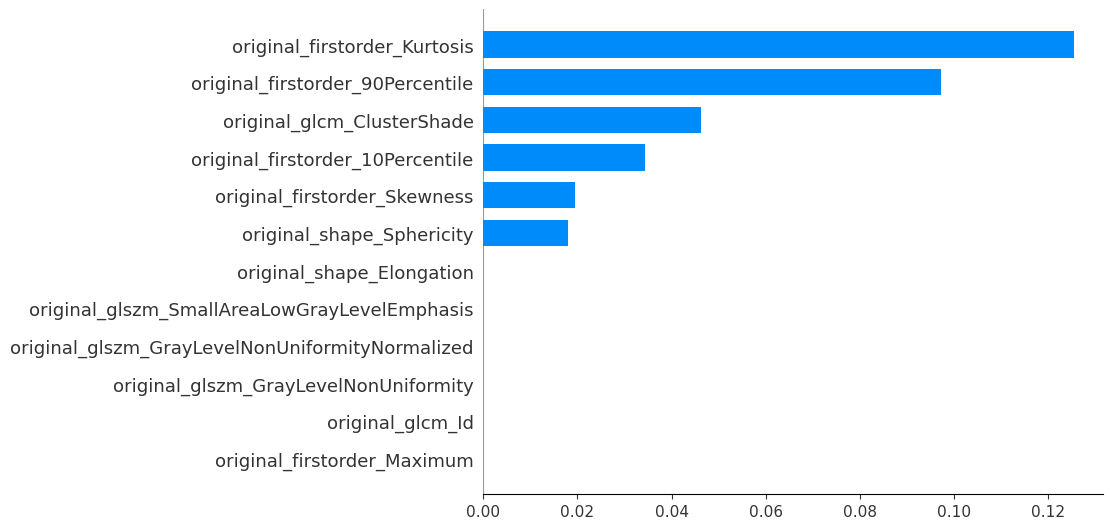

In [35]:
import shap
import matplotlib.pyplot as plt  # 指定绘图库的别名

# ... (之前的代码)

# 1. 计算SHAP值
explainer = shap.TreeExplainer(best_clf['clf'])
shap_values = explainer.shap_values(select_features_train)

# 2. 可视化SHAP值
shap.summary_plot(shap_values, select_features_train, feature_names=names, plot_type="bar")


TypeError: 'list' object is not callable

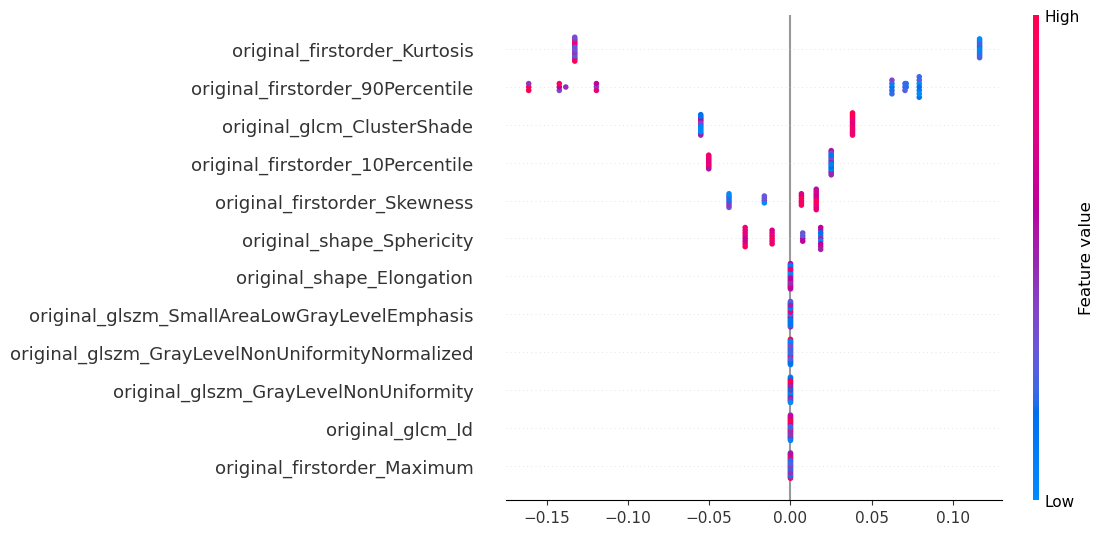

In [45]:
shap.summary_plot(shap_values, select_features_train, max_display=15)

In [109]:
shap.force_plot(explainer.expected_value, shap_values[17], select_features_train.iloc[17,:])

In [69]:
select_features_train.iloc[2,:]

original_firstorder_10Percentile                  -1.219222
original_firstorder_90Percentile                  -1.273610
original_firstorder_Kurtosis                      -0.464103
original_firstorder_Maximum                       -0.440377
original_firstorder_Skewness                       0.793107
original_glcm_ClusterShade                         0.801887
original_glcm_Id                                   0.455359
original_glszm_GrayLevelNonUniformity              1.003488
original_glszm_GrayLevelNonUniformityNormalized   -0.298533
original_glszm_SmallAreaLowGrayLevelEmphasis      -0.456486
original_shape_Elongation                         -0.486749
original_shape_Sphericity                         -0.267585
Name: 2, dtype: float64

In [82]:
shap_values[1]

array([ 0.02506456,  0.07043044, -0.13265674,  0.        ,  0.01584479,
        0.03815252,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.02785665], dtype=float32)